#### Loading in the data

In [18]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf
import plotly.graph_objects as go
from prophet import Prophet
from colorama import Fore
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from scipy.stats import zscore
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from arch import arch_model

In [3]:
ticker = 'GC=F'  # Gold Futures ticker on Yahoo Finance
gold = yf.download(ticker, start='2016-01-01', end='2025-01-01', interval='1d')
gold.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,GC=F,GC=F,GC=F,GC=F,GC=F
Date,,,,,
2016-01-04,1075.099976,1082.500000,1063.199951,1063.400024,143
2016-01-05,1078.400024,1081.500000,1075.300049,1075.599976,82
2016-01-06,1091.900024,1093.699951,1081.599976,1081.599976,52
2016-01-07,1107.699951,1109.400024,1091.599976,1091.599976,122
2016-01-08,1097.800049,1111.099976,1093.000000,1111.099976,98


In [4]:
gold.to_csv('gold_prices_2016_2025.csv')

#### Checking the data


Removing the "ticker" row

In [5]:
gold.columns = gold.columns.droplevel(1)
gold.head()

Price,Close,High,Low,Open,Volume
Date,,,,,
2016-01-04,1075.099976,1082.500000,1063.199951,1063.400024,143
2016-01-05,1078.400024,1081.500000,1075.300049,1075.599976,82
2016-01-06,1091.900024,1093.699951,1081.599976,1081.599976,52
2016-01-07,1107.699951,1109.400024,1091.599976,1091.599976,122
2016-01-08,1097.800049,1111.099976,1093.000000,1111.099976,98


In [6]:
gold.dtypes

Price
Close     float64
High      float64
Low       float64
Open      float64
Volume      int64
dtype: object

In [7]:
gold = gold[['Close']]
gold.head()

Price,Close
Date,
2016-01-04,1075.099976
2016-01-05,1078.400024
2016-01-06,1091.900024
2016-01-07,1107.699951
2016-01-08,1097.800049


In [8]:
gold['Close_Diff'] = gold['Close'].diff()
gold['Close_Log'] = np.log(gold['Close'])
gold['Close_Log_Diff'] = gold['Close_Log'].diff()

# Drop NaN values caused by differencing
gold.dropna(subset=['Close_Diff', 'Close_Log', 'Close_Log_Diff'], inplace=True)

In [9]:
series_list = {
    'Close_Diff': gold['Close_Diff'],
    'Close_Log': gold['Close_Log'],
    'Close_Log_Diff': gold['Close_Log_Diff']
}

for label, series in series_list.items():
    adf_test = adfuller(series)
    adf_p_value = adf_test[1]
    if adf_p_value < 0.05:
        print(f"{label} is stationary, with p-value: {adf_p_value}")
    else:
        print(f"{label} is non-stationary, with p-value: {adf_p_value}")

Close_Diff is stationary, with p-value: 0.0
Close_Log is non-stationary, with p-value: 0.9029816332621483
Close_Log_Diff is stationary, with p-value: 0.0


In [10]:
gold.head()

Price,Close,Close_Diff,Close_Log,Close_Log_Diff
Date,,,,
2016-01-05,1078.400024,3.300049,6.983234,0.003065
2016-01-06,1091.900024,13.500000,6.995675,0.012441
2016-01-07,1107.699951,15.799927,7.010041,0.014366
2016-01-08,1097.800049,-9.899902,7.001064,-0.008978
2016-01-11,1096.500000,-1.300049,6.999879,-0.001185


#### Moving Average

In [11]:
gold['SMA_7'] = gold['Close'].rolling(window=7).mean()



In [12]:
gold['30_day_MA'] = gold['Close'].rolling(window=30).mean()

#### Arima

In [13]:
df_arima = gold.copy()
df_arima

Price,Close,Close_Diff,Close_Log,Close_Log_Diff,SMA_7,30_day_MA
Date,,,,,,
2016-01-05,1078.400024,3.300049,6.983234,0.003065,NaN,NaN
2016-01-06,1091.900024,13.500000,6.995675,0.012441,NaN,NaN
2016-01-07,1107.699951,15.799927,7.010041,0.014366,NaN,NaN
2016-01-08,1097.800049,-9.899902,7.001064,-0.008978,NaN,NaN
2016-01-11,1096.500000,-1.300049,6.999879,-0.001185,NaN,NaN
...,...,...,...,...,...,...
2024-12-24,2620.000000,7.699951,7.870930,0.002943,2626.499965,2638.016667
2024-12-26,2638.800049,18.800049,7.878080,0.007150,2624.699986,2639.310002
2024-12-27,2617.199951,-21.600098,7.869860,-0.008219,2620.814279,2640.523332


In [24]:
df_arima.drop(columns=['Close_Log_Diff', 'Close_Diff', 'Close_Log', 'SMA_7',	'30_day_MA'], inplace=True)
df_arima

Price,Close
Date,
2016-01-05,1078.400024
2016-01-06,1091.900024
2016-01-07,1107.699951
2016-01-08,1097.800049
2016-01-11,1096.500000
...,...
2024-12-24,2620.000000
2024-12-26,2638.800049
2024-12-27,2617.199951


In [13]:
desired_frequency = 'D'
df_arima = df_arima.asfreq(desired_frequency)
df_arima = df_arima.fillna(method='ffill')
df_arima

C:\Users\Wiola\AppData\Local\Temp\ipykernel_8428\4147986448.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_arima = df_arima.fillna(method='ffill')


Price,Close,Close_Diff,Close_Log,Close_Log_Diff,SMA_7,30_day_MA
Date,,,,,,
2016-01-05,1078.400024,3.300049,6.983234,0.003065,NaN,NaN
2016-01-06,1091.900024,13.500000,6.995675,0.012441,NaN,NaN
2016-01-07,1107.699951,15.799927,7.010041,0.014366,NaN,NaN
2016-01-08,1097.800049,-9.899902,7.001064,-0.008978,NaN,NaN
2016-01-09,1097.800049,-9.899902,7.001064,-0.008978,NaN,NaN
...,...,...,...,...,...,...
2024-12-27,2617.199951,-21.600098,7.869860,-0.008219,2620.814279,2640.523332
2024-12-28,2617.199951,-21.600098,7.869860,-0.008219,2620.814279,2640.523332
2024-12-29,2617.199951,-21.600098,7.869860,-0.008219,2620.814279,2640.523332


In [14]:
train_size = int(len(df_arima) * 0.8)  
train, test = df_arima.iloc[:train_size], df_arima.iloc[train_size:]

In [31]:
rolmean = df_arima['Close_Log_Diff'].rolling(14).mean()
rolstd = df_arima['Close_Log_Diff'].rolling(14).std()

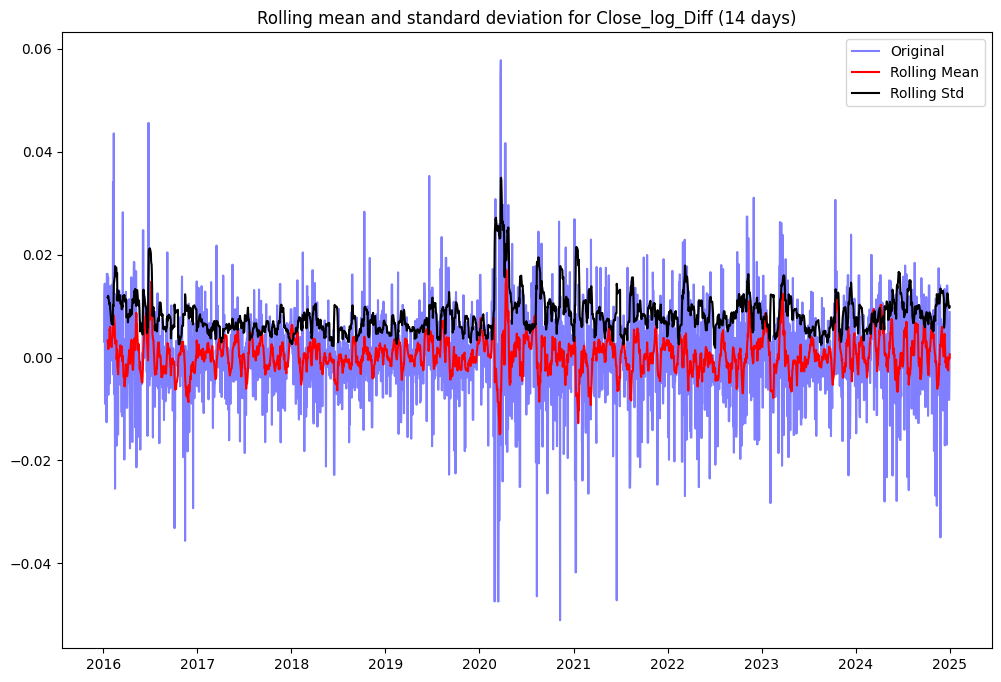

In [32]:
plt.figure(figsize=(12,8))
orig = plt.plot(df_arima['Close_Log_Diff'], color = 'blue', label = 'Original', alpha=0.5)
mean = plt.plot(rolmean, color = 'red', label='Rolling Mean')
std = plt.plot(rolstd, color = 'black', label= "Rolling Std")
plt.title("Rolling mean and standard deviation for Close_log_Diff (14 days)")
plt.legend(loc='best')
plt.show()

In [ ]:
p_values = [1, 2, 3]
q_values = [1, 2, 3]
d_values = [1, 2, 3]

best_aic = np.inf
best_bic = np.inf
best_model = None
best_p, best_q, best_d = None, None, None

for p in p_values:
    for q in q_values:
        for d in d_values:
            try:
                model = ARIMA(train["Close"], order=(p,d,q))
                model_fit = model.fit()
            
                if model_fit.aic < best_aic:
                    best_aic = model_fit.aic
                    best_bic = model_fit.bic
                    best_model = model_fit
                    best_p, best_d, best_q = p, d, q

            except Exception as e:
                print(f"Error fitting ARIMA({p},{d},{q}): {e}")


In [43]:
print(f"Best Model: ARIMA({best_p},{best_d}, {best_q})")
print(f"AIC: {best_aic}")
print(f"BIC: {best_bic}")

Best Model: ARIMA(2,1, 2)
AIC: 20682.056045723963
BIC: 20711.422130998275


In [44]:
# Fit ARIMA model
model = ARIMA(train["Close"], order=(2,1,2))
model_fit = model.fit()


In [45]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 2627
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -10336.028
Date:                Wed, 22 Jan 2025   AIC                          20682.056
Time:                        15:20:42   BIC                          20711.422
Sample:                    01-05-2016   HQIC                         20692.691
                         - 03-15-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.8773      0.010   -182.467      0.000      -1.897      -1.857
ar.L2         -0.9773      0.010    -95.624      0.000      -0.997      -0.957
ma.L1          1.8856      0.010    193.756      0.000       1.866       1.905
ma.L2          0.9810      0.009    103.713      0.000       0.962       1.000
sigma2       153.5545      1.842     83.355      0.000     149.944     157.165
===================================================================================
Ljung-Box (L1) (Q):                   1.87   Jarque-Bera (JB):             10120.38
Prob(Q):                              0.17   Prob(JB):                         0.00
Heteroskedasticity (H):               2.84   Skew:                            -0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [46]:
forecast = model_fit.forecast(steps=len(test))


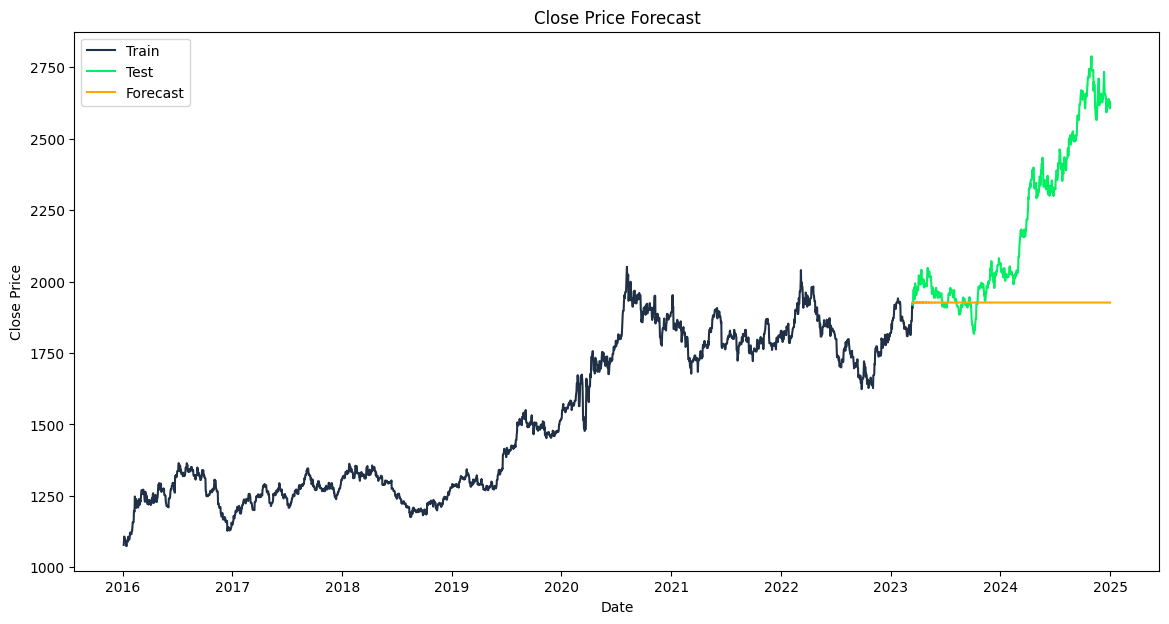

In [47]:
plt.figure(figsize=(14,7))
plt.plot(train.index, train["Close"], label='Train', color='#203147')
plt.plot(test.index, test["Close"], label='Test', color='#01ef63')
plt.plot(test.index, forecast, label='Forecast', color='orange')
plt.title('Close Price Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [182]:
mse = mean_squared_error(test['Close_Log_Diff'], forecasts_arima)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 7.969630993829633e-05


#### GARCH

In [15]:
df_garch = gold.copy()
df_garch

Price,Close,Close_Diff,Close_Log,Close_Log_Diff,SMA_7,30_day_MA
Date,,,,,,
2016-01-05,1078.400024,3.300049,6.983234,0.003065,NaN,NaN
2016-01-06,1091.900024,13.500000,6.995675,0.012441,NaN,NaN
2016-01-07,1107.699951,15.799927,7.010041,0.014366,NaN,NaN
2016-01-08,1097.800049,-9.899902,7.001064,-0.008978,NaN,NaN
2016-01-11,1096.500000,-1.300049,6.999879,-0.001185,NaN,NaN
...,...,...,...,...,...,...
2024-12-24,2620.000000,7.699951,7.870930,0.002943,2626.499965,2638.016667
2024-12-26,2638.800049,18.800049,7.878080,0.007150,2624.699986,2639.310002
2024-12-27,2617.199951,-21.600098,7.869860,-0.008219,2620.814279,2640.523332


In [23]:
df_garch['Returns'] = (np.log(df_garch['Close'] / df_garch['Close'].shift(1))) *100
df_garch.drop(columns=['Close', 'Close_Diff', 'Close_Log', 'Close_Log_Diff', 'SMA_7', '30_day_MA'], inplace=True)
df_garch

Price,Returns
Date,
2016-01-05,NaN
2016-01-06,1.244084
2016-01-07,1.436643
2016-01-08,-0.897753
2016-01-11,-0.118493
...,...
2024-12-24,0.294324
2024-12-26,0.714997
2024-12-27,-0.821926


In [61]:
df_garch.fillna(method='bfill', inplace = True)
df_garch

C:\Users\Wiola\AppData\Local\Temp\ipykernel_14440\2105966302.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_garch.fillna(method='bfill', inplace = True)


Price,Returns
Date,
2016-01-05,1.244084
2016-01-06,1.244084
2016-01-07,1.436643
2016-01-08,-0.897753
2016-01-11,-0.118493
...,...
2024-12-24,0.294324
2024-12-26,0.714997
2024-12-27,-0.821926


In [62]:
train_size = int(len(df_garch) * 0.8)  
train_g, test_g = df_garch.iloc[:train_size], df_garch.iloc[train_size:]

In [68]:
#Finding the best model of GARCH


p_values = [1, 2, 3, 4, 5]
q_values = [1, 2, 3, 4, 5]

best_aic = np.inf
best_bic = np.inf
best_model = None
best_p, best_q = None, None

for p in p_values:
    for q in q_values:
        try:
            model = arch_model(train_g['Returns'], vol='Garch', p=p, q=q, mean='Constant')
            model_fit = model.fit(disp='off')
            
            if model_fit.aic < best_aic:
                best_aic = model_fit.aic
                best_bic = model_fit.bic
                best_model = model_fit
                best_p, best_q = p, q

        except Exception as e:
            print(f"Error fitting GARCH({p},{q}): {e}")

print(f"Best Model: GARCH({best_p},{best_q})")
print(f"AIC: {best_aic}")
print(f"BIC: {best_bic}")

Best Model: GARCH(3,5)
AIC: 4705.209950577341
BIC: 4760.209715986863


In [69]:
model = arch_model(train_g['Returns'], vol='Garch', p=3, q=5, mean='Constant', dist='normal')
fit = model.fit(disp="off")

horizon = len(test_g['Returns'])
forecast = fit.forecast(horizon=horizon, reindex=False)
forecasted_volatility = np.sqrt(forecast.variance.values[-1])

actual_volatility = test_g['Returns']**2  # Use squared returns as a proxy for realized variance
mse = mean_squared_error(actual_volatility, forecasted_volatility**2)  # Compare variances
print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 1.980632526095564


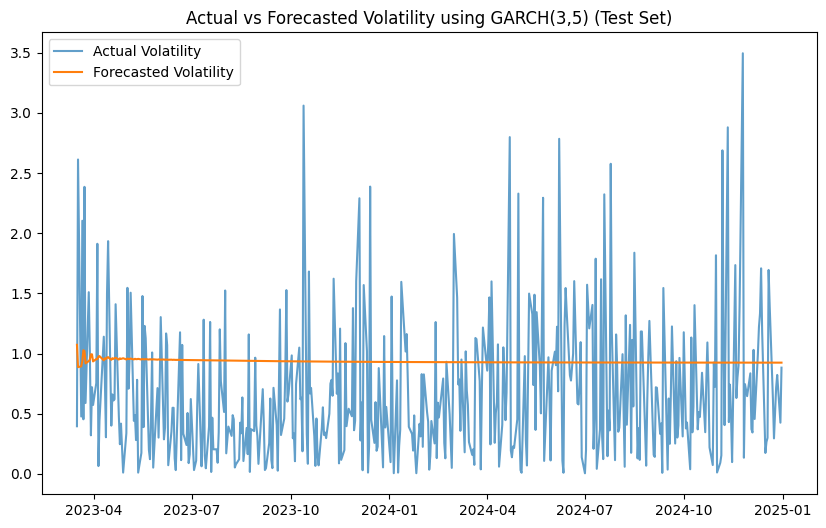

In [70]:
plt.figure(figsize=(10, 6))
plt.plot(test_g.index,  np.sqrt(actual_volatility), label="Actual Volatility", alpha=0.7)
plt.plot(test_g.index, forecasted_volatility, label="Forecasted Volatility")
plt.title("Actual vs Forecasted Volatility using GARCH(3,5) (Test Set)")
plt.legend()
plt.show()

#### Rolling Forecast (GARCH)

In [71]:
train_g

Price,Returns
Date,
2016-01-05,1.244084
2016-01-06,1.244084
2016-01-07,1.436643
2016-01-08,-0.897753
2016-01-11,-0.118493
...,...
2023-03-09,0.911599
2023-03-10,1.771777
2023-03-13,2.634169


In [72]:
tstart = "2016-01-05"
tend = "2023-03-15"

In [73]:
def train_test_split_garch(dataset, tstart, tend):
    tend_next = pd.to_datetime(tend) + pd.Timedelta(days=1)

    train = df_garch.loc[tstart:tend, "Returns"].values
    test = df_garch.loc[tend_next:, "Returns"].values
    return train, test

training_set_garch, test_set_garch = train_test_split_garch(df_garch, tstart, tend)


In [79]:
#Rolling forecast
test_size = len(test_set_garch)
rolling_predictions = []
for i in range(test_size):
    train = df_garch['Returns'][:-(test_size-i)]
    model = arch_model(train, p=3, q=5)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon = 1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

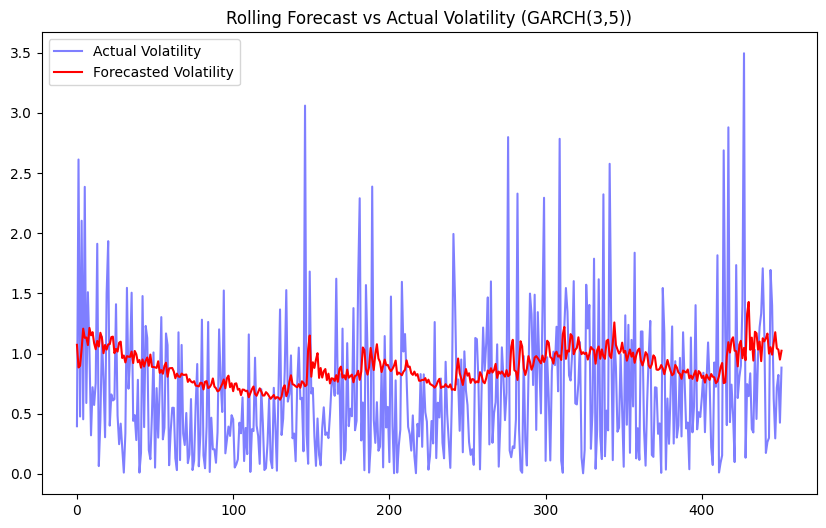

In [80]:
actual_volatility = np.sqrt(test_set_garch**2) 
plt.figure(figsize=(10, 6))
plt.plot(actual_volatility, label="Actual Volatility", color='blue', alpha=0.5)
plt.plot(rolling_predictions, label="Forecasted Volatility", color='red')
plt.title("Rolling Forecast vs Actual Volatility (GARCH(3,5))")
plt.legend()
plt.show()